Starting from the basic CNN of the exercise session, we decided to include the data augmentation. This first experiment led to better results than the previous version without data augmentation.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/'[ANNDL] GengisGAN'/CH1

/gdrive/.shortcut-targets-by-id/1TOt28-RT2lbTOV30p7HtP17CjDAEpHgm/[ANNDL] GengisGAN/CH1


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace training/Apple/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
#import splitfolders

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


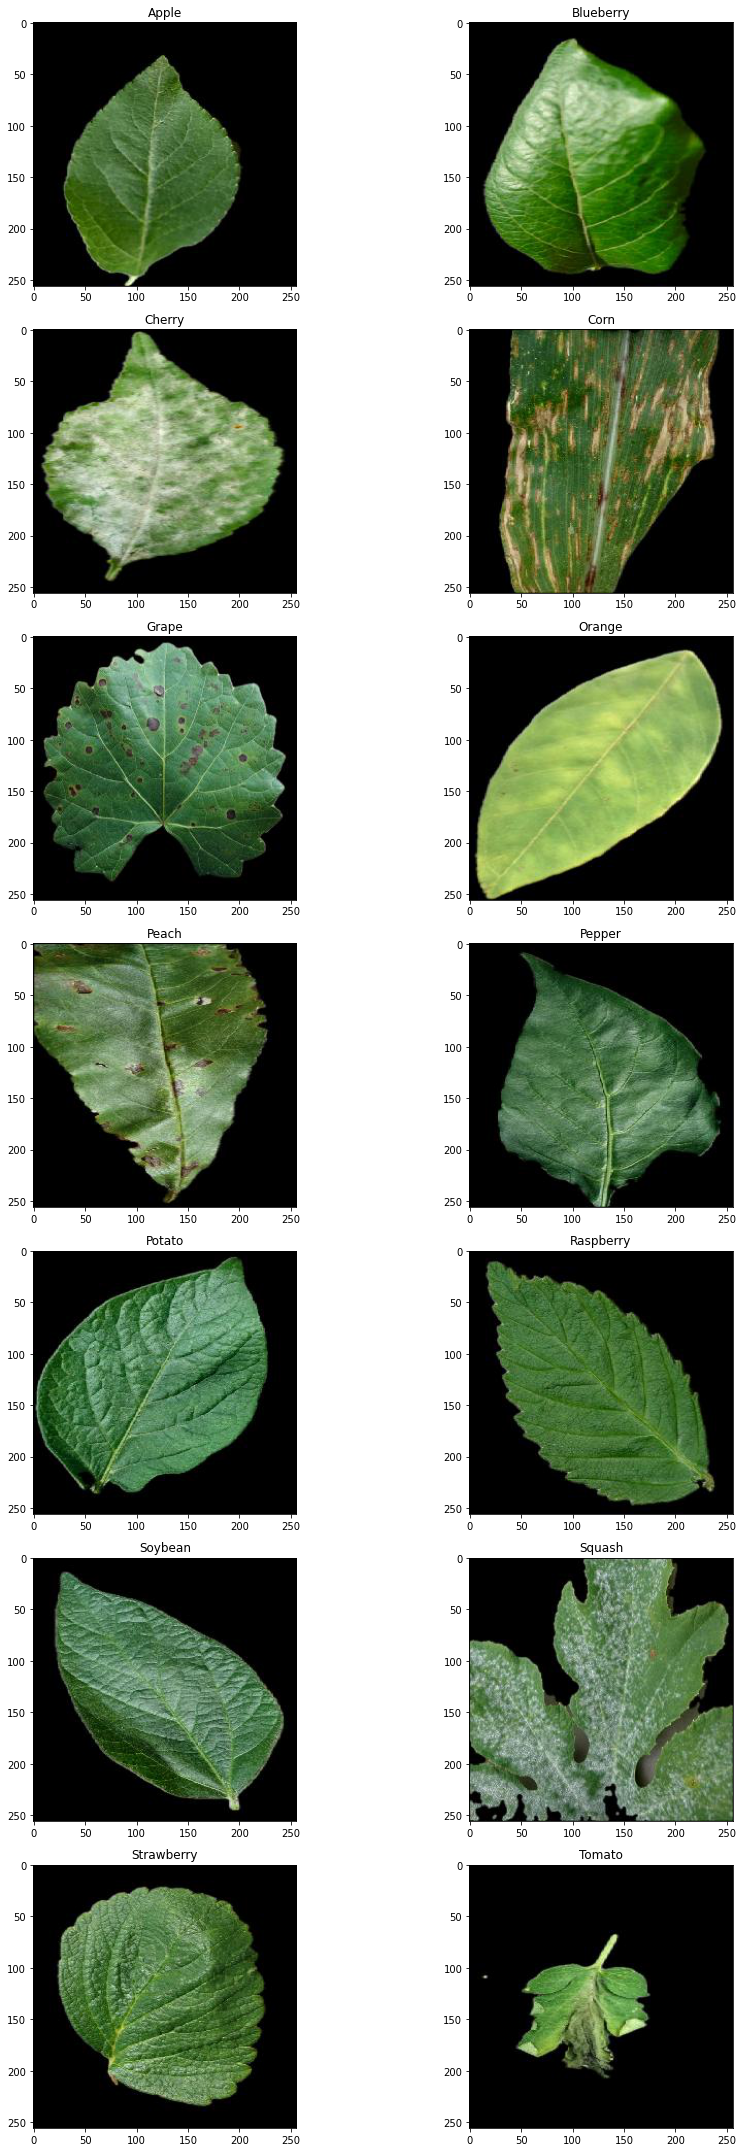

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Set Seed

In [ ]:
# Random seed for reproducibility

n_classes = 14
seed = 22 #Gonzales o Chiesa

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

dataset_dir = 'training'

In [ ]:
#splitfolders.ratio(dataset_dir, output="Split", seed=seed, ratio=(.7, 0.15,0.15)) 

#Data Loader

In [ ]:
train_dir = "Split/train"
val_dir = "Split/val"
test_dir = "Split/test"

# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1/255.)
val_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=train_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
val_gen = val_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)


Found 12403 images belonging to 14 classes.
Found 2652 images belonging to 14 classes.
Found 2673 images belonging to 14 classes.


In [ ]:
#TODO
#Data augmentation, come portare tutte le classi allo stesso numero di elementi
#capire forma del submit

#Data Loader with augmentation

Data augmentation has been implemented only on the training set. We could train the network two times: one with data augmentation and another one without, then submit both the networks in order to show an improvement on the leaderboard (or, at least, I hope so)

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
# TODO: we have to reason on the right values for the parameters of the
# generator.

aug_train_data_gen = ImageDataGenerator(rotation_range=45,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=train_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

Found 12403 images belonging to 14 classes.


# Model definition

Here we have defined the model for this first implementation. It is a CNN with the following structure: (Conv + ReLU + MaxPool) x 5 + FC x 2

This is the model of the CNN that was used as an example during the exercise session.

#### Model metadata


In [ ]:
input_shape = (256, 256, 3)
epochs = 200


#### CNN definition

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=n_classes, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
1551/1551 [==============================] - ETA: 0s - loss: 1.8283 - accuracy: 0.4299

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 7124s 5s/step - loss: 1.8283 - accuracy: 0.4299 - val_loss: 1.5051 - val_accuracy: 0.5271
Epoch 2/200
1551/1551 [==============================] - ETA: 0s - loss: 1.2802 - accuracy: 0.5928

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 255s 164ms/step - loss: 1.2802 - accuracy: 0.5928 - val_loss: 0.9439 - val_accuracy: 0.6991
Epoch 3/200
1551/1551 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.6572

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 256s 165ms/step - loss: 1.0439 - accuracy: 0.6572 - val_loss: 0.8367 - val_accuracy: 0.7308
Epoch 4/200
1551/1551 [==============================] - ETA: 0s - loss: 0.9117 - accuracy: 0.7100

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 299s 193ms/step - loss: 0.9117 - accuracy: 0.7100 - val_loss: 0.6221 - val_accuracy: 0.8009
Epoch 5/200
1551/1551 [==============================] - ETA: 0s - loss: 0.8090 - accuracy: 0.7376

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 259s 167ms/step - loss: 0.8090 - accuracy: 0.7376 - val_loss: 0.4959 - val_accuracy: 0.8367
Epoch 6/200
1551/1551 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.7616

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 261s 168ms/step - loss: 0.7353 - accuracy: 0.7616 - val_loss: 0.6376 - val_accuracy: 0.8073
Epoch 7/200
1551/1551 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7918

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 270s 174ms/step - loss: 0.6550 - accuracy: 0.7918 - val_loss: 0.5350 - val_accuracy: 0.8254
Epoch 8/200
1551/1551 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.7948

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 271s 175ms/step - loss: 0.6356 - accuracy: 0.7948 - val_loss: 0.4803 - val_accuracy: 0.8477
Epoch 9/200
1551/1551 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.8143

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 264s 170ms/step - loss: 0.5748 - accuracy: 0.8143 - val_loss: 0.4013 - val_accuracy: 0.8654
Epoch 10/200
1551/1551 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.8262

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 264s 170ms/step - loss: 0.5435 - accuracy: 0.8262 - val_loss: 0.3986 - val_accuracy: 0.8646
Epoch 11/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4975 - accuracy: 0.8402

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 268s 173ms/step - loss: 0.4975 - accuracy: 0.8402 - val_loss: 0.4005 - val_accuracy: 0.8710
Epoch 12/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8508

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 281s 181ms/step - loss: 0.4819 - accuracy: 0.8508 - val_loss: 0.3300 - val_accuracy: 0.8910
Epoch 13/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.8470

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 266s 172ms/step - loss: 0.4655 - accuracy: 0.8470 - val_loss: 0.2725 - val_accuracy: 0.9106
Epoch 14/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.8523

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 262s 169ms/step - loss: 0.4578 - accuracy: 0.8523 - val_loss: 0.2610 - val_accuracy: 0.9155
Epoch 15/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.8596

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 260s 168ms/step - loss: 0.4339 - accuracy: 0.8596 - val_loss: 0.3756 - val_accuracy: 0.8816
Epoch 16/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.8691

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 262s 169ms/step - loss: 0.4331 - accuracy: 0.8691 - val_loss: 0.3526 - val_accuracy: 0.8801
Epoch 17/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4177 - accuracy: 0.8667

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 258s 166ms/step - loss: 0.4177 - accuracy: 0.8667 - val_loss: 0.2207 - val_accuracy: 0.9295
Epoch 18/200
1551/1551 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8726

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 250s 161ms/step - loss: 0.4149 - accuracy: 0.8726 - val_loss: 0.2251 - val_accuracy: 0.9280
Epoch 19/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8761

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 249s 161ms/step - loss: 0.3865 - accuracy: 0.8761 - val_loss: 0.2141 - val_accuracy: 0.9355
Epoch 20/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8816

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 240s 155ms/step - loss: 0.3831 - accuracy: 0.8816 - val_loss: 0.2465 - val_accuracy: 0.9212
Epoch 21/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8796

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 269s 174ms/step - loss: 0.3936 - accuracy: 0.8796 - val_loss: 0.2248 - val_accuracy: 0.9231
Epoch 22/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8858

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 268s 173ms/step - loss: 0.3623 - accuracy: 0.8858 - val_loss: 0.1821 - val_accuracy: 0.9393
Epoch 23/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8874

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 259s 167ms/step - loss: 0.3633 - accuracy: 0.8874 - val_loss: 0.2197 - val_accuracy: 0.9238
Epoch 24/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8872

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 262s 169ms/step - loss: 0.3734 - accuracy: 0.8872 - val_loss: 0.2335 - val_accuracy: 0.9268
Epoch 25/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8856

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 259s 167ms/step - loss: 0.3838 - accuracy: 0.8856 - val_loss: 0.1961 - val_accuracy: 0.9385
Epoch 26/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8881

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 254s 163ms/step - loss: 0.3746 - accuracy: 0.8881 - val_loss: 0.2094 - val_accuracy: 0.9299
Epoch 27/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8902

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 250s 161ms/step - loss: 0.3505 - accuracy: 0.8902 - val_loss: 0.2409 - val_accuracy: 0.9182
Epoch 28/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8888

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 247s 159ms/step - loss: 0.3534 - accuracy: 0.8888 - val_loss: 0.1989 - val_accuracy: 0.9317
Epoch 29/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8903

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 245s 158ms/step - loss: 0.3668 - accuracy: 0.8903 - val_loss: 0.3345 - val_accuracy: 0.8937
Epoch 30/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8970

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 272s 175ms/step - loss: 0.3438 - accuracy: 0.8970 - val_loss: 0.2570 - val_accuracy: 0.9129
Epoch 31/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8903

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 270s 174ms/step - loss: 0.3498 - accuracy: 0.8903 - val_loss: 0.2199 - val_accuracy: 0.9348
Epoch 32/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8933

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 266s 171ms/step - loss: 0.3385 - accuracy: 0.8933 - val_loss: 0.1397 - val_accuracy: 0.9563
Epoch 33/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.8984

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 258s 166ms/step - loss: 0.3437 - accuracy: 0.8984 - val_loss: 0.1579 - val_accuracy: 0.9551
Epoch 34/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8977

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 259s 167ms/step - loss: 0.3354 - accuracy: 0.8977 - val_loss: 0.2136 - val_accuracy: 0.9355
Epoch 35/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8956

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 257s 166ms/step - loss: 0.3413 - accuracy: 0.8956 - val_loss: 0.1753 - val_accuracy: 0.9465
Epoch 36/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8945

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 255s 165ms/step - loss: 0.3601 - accuracy: 0.8945 - val_loss: 0.2667 - val_accuracy: 0.9189
Epoch 37/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8966

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 250s 161ms/step - loss: 0.3420 - accuracy: 0.8966 - val_loss: 0.2270 - val_accuracy: 0.9333
Epoch 38/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8992

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 248s 160ms/step - loss: 0.3306 - accuracy: 0.8992 - val_loss: 0.1884 - val_accuracy: 0.9472
Epoch 39/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.9055

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 265s 171ms/step - loss: 0.3120 - accuracy: 0.9055 - val_loss: 0.1547 - val_accuracy: 0.9532
Epoch 40/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8997

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 285s 184ms/step - loss: 0.3499 - accuracy: 0.8997 - val_loss: 0.2255 - val_accuracy: 0.9340
Epoch 41/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8997

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 283s 182ms/step - loss: 0.3365 - accuracy: 0.8997 - val_loss: 0.1888 - val_accuracy: 0.9385
Epoch 42/200
1551/1551 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8957

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Nov15_16-19-24/ckpts/cp.ckpt/assets


1551/1551 [==============================] - 274s 177ms/step - loss: 0.3425 - accuracy: 0.8957 - val_loss: 0.1560 - val_accuracy: 0.9563


In [ ]:
model.save("data_augmentation_experiments/CNN_Aug_Base")

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Base/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_Aug_Base/assets


In [ ]:
model_aug = tfk.models.load_model("CH1/models/CNN_Aug_Base")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

335/335 [==============================] - 1293s 4s/step - loss: 0.1390 - accuracy: 0.9570
